# Student Succes Dataset

This notebook will contains some of my work on a dataset found on Kaggle (https://www.kaggle.com/competitions/playground-series-s4e6/data?select=test.csv). Note that this is a synthetic dataset created with the goal of The goal of this competition is to predict academic risk of students in higher education.

### Import Libraries


In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
import xgboost as xgb


### Look at Data

In [229]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [230]:
id_col = test["id"]
test.drop(columns=["id"], inplace=True)

In [231]:
train.drop(columns=["id"], inplace=True)
train.shape

(76518, 37)

In [176]:
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


### Removing Outliers


In [232]:
def check_and_remove_outliers(df):

    outliers_columns = []
    total_rows = len(df)
    
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / total_rows) * 100
        
        if outlier_percentage >= 20:
            outliers_columns.append(column)
            print(f"Outliers detected in column '{column}': {outlier_percentage:.2f}% of total rows.")
            
            # Remove outliers from the DataFrame
            df = df[~outliers]
            print(f"Removed {outlier_count} outliers from column '{column}'.")
    
    if not outliers_columns:
        print("No columns with outliers exceeding 20% detected.")

    return df
df = check_and_remove_outliers(train)

Outliers detected in column 'Scholarship holder': 24.74% of total rows.
Removed 18930 outliers from column 'Scholarship holder'.


Notes on the meaning of each feature in the dataset (where applicable): <br><br>
       For information about different features of the dataset, info can be found at:
    https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success 

### Target Variable Analysis

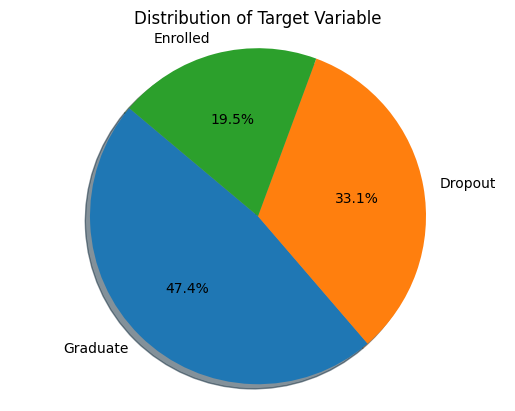

In [178]:
## Plotting Target Feature
target_counts = train["Target"].value_counts()

plt.pie(target_counts,labels=target_counts.index, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title("Distribution of Target Variable")
plt.show()

### Train Test Split

In [233]:
## Encode target variable
le_encoder = LabelEncoder()

## fit and transform target variable
train["Target"] = le_encoder.fit_transform(train["Target"])

In [235]:
## train test split
y = train["Target"]
X = train.drop(columns=["Target"])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


### Model Creation And Evaluation

In [236]:
## Model
clf = RandomForestClassifier(n_estimators = 100, random_state=42)

## Fit Model
clf.fit(X_train, y_train)

## Predict
y_pred = clf.predict(X_test)

In [237]:
## Model Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"accuracy_score : {acc : .2f}")

## Classification Report 
print(classification_report(y_test, y_pred))

accuracy_score :  0.83
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5028
           1       0.65      0.60      0.62      3017
           2       0.85      0.92      0.89      7259

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.83     15304



#### Quick Refresher on Some of these metrics:
1. Percision:
    TP/TP+FP
    The ratio of correctly predicted positive observations

2. Recall:
    The ration of correctly predicted positive observations to all observations in the actual class.
    It tells you how many of the actual positives are caputed by the model

In [183]:
y_pred_original = le_encoder.inverse_transform(y_pred)
y_test_original = le_encoder.inverse_transform(y_test)

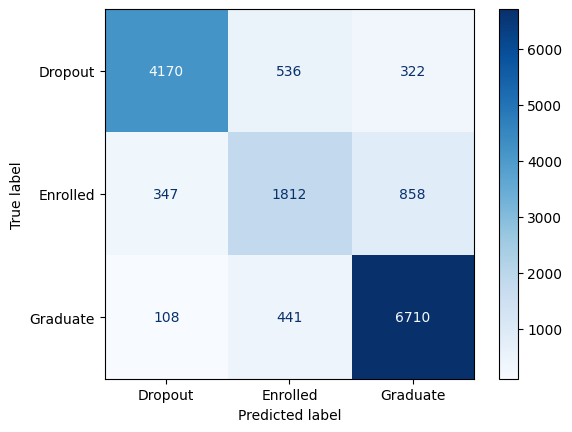

In [184]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_original, y_pred_original, labels=le_encoder.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### What about Oversampling?
- To reduce misclassification of the enrolled class

In [238]:
## Oversampling using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X,y)

### Model Evaluation on Oversampled Data 

In [239]:
## train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=42)

In [240]:
## model creation
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [241]:
## model evaluation
acc = accuracy_score(y_test, y_pred)
print(f"accuracy_score : {acc : .2f}")

## Classification Report 
print(classification_report(y_test, y_pred))

accuracy_score :  0.86
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      7223
           1       0.79      0.84      0.82      7201
           2       0.86      0.89      0.88      7346

    accuracy                           0.86     21770
   macro avg       0.86      0.86      0.86     21770
weighted avg       0.86      0.86      0.86     21770



In [189]:
y_pred_original = le_encoder.inverse_transform(y_pred)
y_test_original = le_encoder.inverse_transform(y_test)

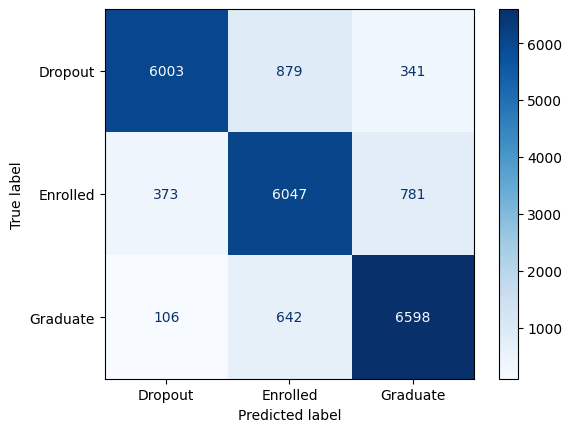

In [190]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_original, y_pred_original, labels=le_encoder.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Feature Selection

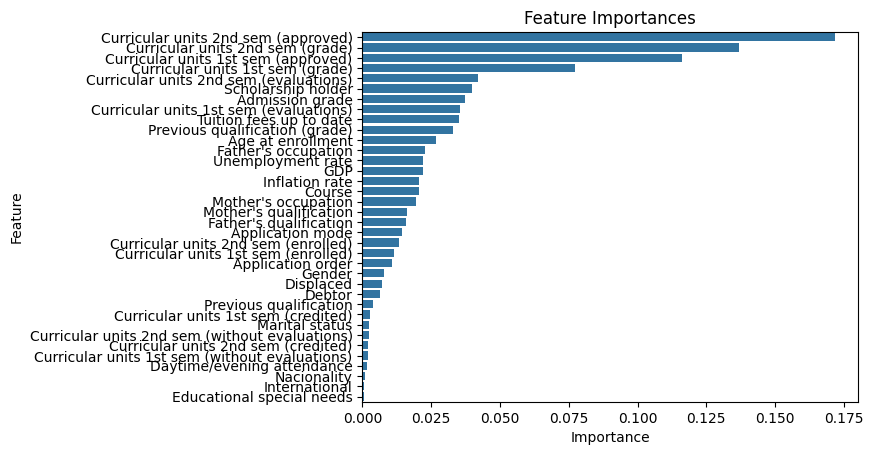

In [242]:
## Random Forest Feature Importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]


sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Recursive Feature Eliminaton

In [192]:
# Number of features to select
n_features_to_select = 30

# Initialize RFE with the model and the number of features to select
rfe = RFE(estimator=clf, n_features_to_select=n_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=30)

In [193]:
# Get the ranking of features
ranking = rfe.ranking_

# Get the mask of selected features
selected_features_mask = rfe.support_

# Get the list of selected feature indices
selected_features_indices = np.where(selected_features_mask)[0]

# Get the list of selected feature names (if available)
# feature_names = [...]  # List of your feature names
# selected_feature_names = [feature_names[i] for i in selected_features_indices]

print(f'Selected feature indices: {selected_features_indices}')
# print(f'Selected feature names: {selected_feature_names}')

Selected feature indices: [ 0  1  2  3  5  6  8  9 10 11 12 13 15 16 17 18 19 21 22 23 24 25 28 29
 30 31 32 33 34 35]


### Random Forest Classifier

In [208]:
# Transform the training and testing data to select the features
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

# Train the model with the selected features
clf.fit(X_train, y_train)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f'Accuracy with selected features: {accuracy}')

Accuracy with selected features: 0.856821313734497


### XGB Classifier

In [211]:
XGB_clf = xgb.XGBClassifier()

params = {
    "n_estimators" : np.arange(100, 200, 50),
    "max_depth" : np.arange(5, 20, 5),
    "learning_rate" : np.arange(0.1, 1, 0.4),
    "subsample" : np.arange(0.2, 1, 0.4),
    "alpha" :  np.arange(0.1, 1, 0.3)
}

XGBsearch = GridSearchCV(estimator=XGB_clf, param_grid=params, scoring="accuracy", n_jobs=-1, cv=5, verbose=1)
XGBsearch.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


0.04s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.4, 0.7]),
                         'learning_rate': array([0.1, 0.5, 0.9]),
                         'max_depth': array([ 5, 10, 15]),
                         'n_estimators': array([100, 150]),
                         'subsample': array([0.2, 0.6])},
             scoring='accuracy', verbose=1)

In [243]:
# Make predictions on the test set
y_pred = XGBsearch.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.9808911345888838
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7223
           1       0.96      0.98      0.97      7201
           2       0.99      1.00      1.00      7346

    accuracy                           0.98     21770
   macro avg       0.98      0.98      0.98     21770
weighted avg       0.98      0.98      0.98     21770



### Training and Submitting Results of Best Model

In [244]:
## function to create the final sub file for kaggle
def create_sub_file(le_encoder, final_pred, id_col):
    final_pred = le_encoder.inverse_transform(final_pred)
    final_sub = pd.DataFrame({"id": id_col, "Target":final_pred})
    final_sub.to_csv('submission.csv', index=False)

In [245]:
clf =  XGBsearch.best_estimator_
clf.fit(X_resampled, y_resampled)

XGBClassifier(alpha=np.float64(0.4), base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=np.float64(0.1),
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(15), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(150), n_jobs=None,
              num_parallel_tree=None, ...)

In [247]:
y_pred = clf.predict(test)

In [248]:
create_sub_file(le_encoder, y_pred, id_col)